In [1759]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/madaline/MadaLine.csv


In [1760]:
df = pd.read_csv('../input/madaline/MadaLine.csv',names=['x1', 'x2','label'],header=None, )
df

,x1,x2,label
0,-0.642823,0.720606,0.0
1,-0.218126,0.677263,0.0
2,-0.582930,-0.347496,0.0
3,0.285127,0.091750,0.0
4,-0.335577,-0.313893,0.0
...,...,...,...
195,0.744066,-1.206548,1.0
196,-0.457547,1.286227,1.0
197,-1.020000,-0.783926,1.0
198,1.363429,-0.800250,1.0


In [1761]:
df = df.sample(frac = 1)
df

,x1,x2,label
87,0.493025,0.335211,0.0
26,-0.032163,0.179866,0.0
76,-0.459566,0.809323,0.0
68,0.356835,0.281295,0.0
78,-0.065032,-0.133571,0.0
...,...,...,...
77,-0.373154,0.687848,0.0
54,-0.932415,0.155296,0.0
179,0.369713,-1.186841,1.0
177,-1.087787,1.011932,1.0


In [1762]:
f = df[['x1','x2']]
x = f.to_numpy()
x.shape[0]

200

In [1763]:
#convert bipolar
label = df[['label']]
t = label.to_numpy()
t[np.isclose(t, 0)] = -1


In [1764]:
df0 = df.loc[df['label']  == 0 ]
df1 = df.loc[df['label']  == 1]

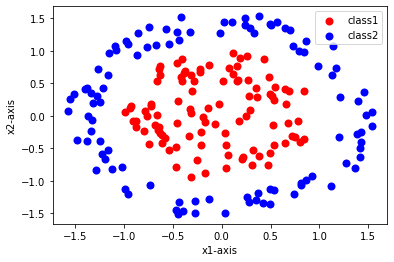

In [1765]:
plt.scatter(df0['x1'], df0['x2'], c ="red",
            linewidths = 2)
 
plt.scatter(df1['x1'], df1['x2'], c ="blue",
            linewidths = 2)
plt.xlabel("x1-axis")
plt.ylabel("x2-axis")
plt.legend(["class1" , "class2"])
plt.show()

In [1766]:
df = df.sample(frac=1, random_state=10).reset_index()
df

,index,x1,x2,label
0,98,0.847037,-0.361148,0.0
1,147,-1.157146,0.957272,1.0
2,49,-0.661087,0.541772,0.0
3,177,-1.087787,1.011932,1.0
4,58,-0.307634,0.380198,0.0
...,...,...,...,...
195,120,1.115133,-1.075341,1.0
196,9,0.067905,-0.601169,0.0
197,124,-0.766417,1.058419,1.0
198,142,0.234326,1.499368,1.0


In [1767]:
def find_separation_line(start,end,w,b):
    x= np.linspace(start,end)
    y = -(w[0] * x + b)
    y = y / w[1]
    return x,y

In [1768]:
def initialize(k,d1,d2):
    np.random.seed(10)
    w = np.random.rand(d1,d2) * k
    b = np.zeros((d1,1))
    v = np.array([[1]*d1])
    b3 = d1 - 1
    return w,b,v,b3

In [1769]:
def activation(net):
    h = np.where(net >= 0, 1, -1)
    return h

In [1770]:
def forward(w,x,b,resh):
    if resh:
        x = x.reshape((2,1))
    z_in = np.dot(w,x) + b
    z = activation(z_in)
    return z_in, z

In [1771]:
def update(w,b,x,t,z_in,y,alpha,d1):
   
    x = x.reshape((1,2))
    z_in = z_in.reshape((d1,1))
    if t == y:
        return w,b
    
    elif t == 1 and t!=y:    #y=-1 but t=1
        argmax_neuron = np.argmax(z_in)
        diff_b = alpha * (1- z_in[argmax_neuron])
        diff_w = alpha * np.dot((1-z_in[argmax_neuron]),x)
        b[argmax_neuron] = b[argmax_neuron] + diff_b
        w[argmax_neuron] = w[argmax_neuron] + diff_w

    elif t == -1 and t !=y:   # y=1 but t=-1
        z_pos = np.argwhere(z_in > 0)
        diff_b = alpha * (-1- z_in)
        diff_w = alpha * np.dot((-1-z_in),x)
        bt = b + diff_b
        wt = w + diff_w
        for i in z_pos[:,0]:
            w[i] = wt[i]
            b[i] = bt[i]
        
    return w,b

In [1772]:
def calculate_error(t,y):
    e = 0.5 * np.power((t - y),2)
    return e

In [1773]:
def predict(x, t,w,b,d1):
    y_hat = []
    b3 = np.zeros((d1,1))
    v = np.array([[1]*d1])
    b3 = d1 - 1
    for i in range(x.shape[0]):
        z_in, z = forward(w,x[i],b,resh = True)
        y_in, y = forward(v,z,b3,resh = False)
        y_hat.append(y[0])
    return y_hat

In [1774]:
def MR1(x,t,d1,d2,learning_rate,max_iter,samples):
    print('sample:',samples)
    k = 0.001
    error_list = []
    errors = []
    mean_error = 10**3
    w,b,v,b3 = initialize(k,d1,d2)  #Step0
    for i in range(max_iter):
        z_in, z = forward(w,x[i%samples],b,resh = True) #Step 4 and 5
        y_in, y = forward(v,z,b3,resh = False) #Step 6
        error = calculate_error(t[i%samples],y)
        errors.append(error)
        if i % samples == 0 and i != 0:
            mean_error = np.mean(errors)
            error_list.append(mean_error)
            errors = []
            print('Epoch %d / %d' % (len(error_list), int(max_iter/samples)))
            print('loss:', mean_error)
        if mean_error == 0 or (i> 50 and error_list[-1] - error_list[-2]):
            print('An early stop occurred!')
            return w,b, error_list
        w,b = update(w,b,x[i%samples],t[i%samples],z_in,y,learning_rate,d1) #Step 7
    return w,b,error_list

## Madaline with 3 neurons

In [1775]:
w, b, error_list = MR1(x,t,d1 =3 ,d2 = 2,max_iter = 200*200,learning_rate = 0.0001,samples = x.shape[0])

sample: 200
Epoch 1 / 200
loss: 0.6169154228855721
Epoch 2 / 200
loss: 0.36
Epoch 3 / 200
loss: 0.28
Epoch 4 / 200
loss: 0.35
Epoch 5 / 200
loss: 0.27
Epoch 6 / 200
loss: 0.3
Epoch 7 / 200
loss: 0.29
Epoch 8 / 200
loss: 0.22
Epoch 9 / 200
loss: 0.3
Epoch 10 / 200
loss: 0.36
Epoch 11 / 200
loss: 0.35
Epoch 12 / 200
loss: 0.28
Epoch 13 / 200
loss: 0.3
Epoch 14 / 200
loss: 0.28
Epoch 15 / 200
loss: 0.29
Epoch 16 / 200
loss: 0.29
Epoch 17 / 200
loss: 0.32
Epoch 18 / 200
loss: 0.21
Epoch 19 / 200
loss: 0.21
Epoch 20 / 200
loss: 0.24
Epoch 21 / 200
loss: 0.27
Epoch 22 / 200
loss: 0.19
Epoch 23 / 200
loss: 0.33
Epoch 24 / 200
loss: 0.28
Epoch 25 / 200
loss: 0.23
Epoch 26 / 200
loss: 0.3
Epoch 27 / 200
loss: 0.34
Epoch 28 / 200
loss: 0.27
Epoch 29 / 200
loss: 0.28
Epoch 30 / 200
loss: 0.28
Epoch 31 / 200
loss: 0.26
Epoch 32 / 200
loss: 0.22
Epoch 33 / 200
loss: 0.26
Epoch 34 / 200
loss: 0.27
Epoch 35 / 200
loss: 0.23
Epoch 36 / 200
loss: 0.22
Epoch 37 / 200
loss: 0.23
Epoch 38 / 200
loss: 0.21

In [1776]:
np.argmin(error_list)

124

In [1777]:
print('line formula: ',w,'x + ',b)

line formula:  [[-0.00015476 -0.00098357]
 [ 0.00097658  0.0005108 ]
 [-0.00141121  0.00090733]] x +  [[-0.00080249]
 [-0.00080557]
 [-0.00160019]]


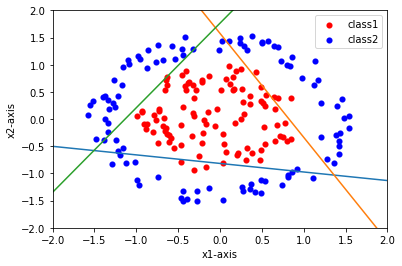

In [1778]:
p1x1,p1x2 = find_separation_line(-2,2,w[0],b[0])
p2x1,p2x2 = find_separation_line(-2,2,w[1],b[1])
p3x1,p3x2 = find_separation_line(-2,2,w[2],b[2])

plt.scatter(df0['x1'], df0['x2'], c ="red",
            linewidths = 0.1)
 
plt.scatter(df1['x1'], df1['x2'], c ="blue",
            linewidths = .1)
plt.plot(p1x1,p1x2)
plt.plot(p2x1,p2x2)
plt.plot(p3x1,p3x2)

plt.xlabel("x1-axis")
plt.ylabel("x2-axis")
plt.legend(["class1" , "class2"])

plt.xlim([-2, 2])
plt.ylim([-2, 2])
 
plt.show()

Text(0, 0.5, 'Loss')

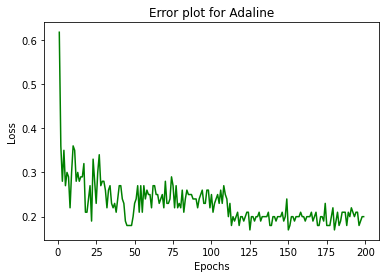

In [1779]:
itr = range(1,len(error_list)+1)
plt.plot(itr, error_list, 'g', label='Training loss')
plt.title('Error plot for Adaline')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [1780]:
y_hat = predict(x, t,w,b,d1=3)
print(classification_report(t, y_hat))


              precision    recall  f1-score   support

        -1.0       0.94      0.93      0.93       100
         1.0       0.93      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



## Madaline with 4 neurons

In [1781]:
w,b, error_list = MR1(x,t,d1 = 4 ,d2 = 2,max_iter = 200*200,learning_rate = 0.01,samples = x.shape[0])

sample: 200
Epoch 1 / 200
loss: 0.5771144278606966
Epoch 2 / 200
loss: 0.33
Epoch 3 / 200
loss: 0.21
Epoch 4 / 200
loss: 0.25
Epoch 5 / 200
loss: 0.16
Epoch 6 / 200
loss: 0.15
Epoch 7 / 200
loss: 0.17
Epoch 8 / 200
loss: 0.16
Epoch 9 / 200
loss: 0.13
Epoch 10 / 200
loss: 0.07
Epoch 11 / 200
loss: 0.08
Epoch 12 / 200
loss: 0.11
Epoch 13 / 200
loss: 0.04
Epoch 14 / 200
loss: 0.04
Epoch 15 / 200
loss: 0.04
Epoch 16 / 200
loss: 0.04
Epoch 17 / 200
loss: 0.09
Epoch 18 / 200
loss: 0.02
Epoch 19 / 200
loss: 0.0
An early stop occurred!


In [1782]:
print('line formula: ',w,'x + ',b)

line formula:  [[ 0.00963462 -0.05555394]
 [-0.06070435 -0.00187536]
 [-0.02069995  0.06445672]
 [ 0.05952812  0.02343096]] x +  [[-0.0504731 ]
 [-0.06200256]
 [-0.0711899 ]
 [-0.06122411]]


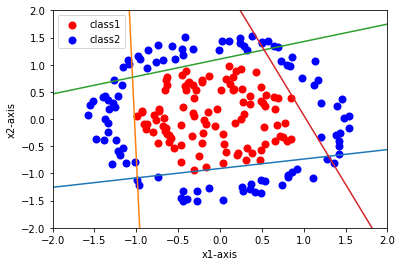

In [1783]:
p1x1,p1x2 = find_separation_line(-2,2,w[0],b[0])
p2x1,p2x2 = find_separation_line(-2,2,w[1],b[1])
p3x1,p3x2 = find_separation_line(-2,2,w[2],b[2])
p4x1,p4x2 = find_separation_line(-2,2,w[3],b[3])

plt.scatter(df0['x1'], df0['x2'], c ="red",
            linewidths = 2)
 
plt.scatter(df1['x1'], df1['x2'], c ="blue",
            linewidths = 2)
plt.plot(p1x1,p1x2)
plt.plot(p2x1,p2x2)
plt.plot(p3x1,p3x2)
plt.plot(p4x1,p4x2)


plt.xlabel("x1-axis")
plt.ylabel("x2-axis")
plt.legend(["class1" , "class2"])

plt.xlim([-2, 2])
plt.ylim([-2, 2])
 
plt.show()

Text(0, 0.5, 'Loss')

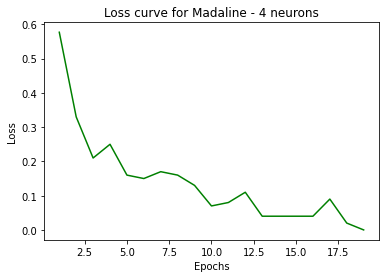

In [1784]:
itr = range(1,len(error_list)+1)
plt.plot(itr, error_list, 'g', label='Training loss')
plt.title('Loss curve for Madaline - 4 neurons')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [1785]:
y_hat = predict(x, t,w,b,d1=4)
print(classification_report(t, y_hat))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



## Madaline with 8 neurons

In [1786]:
w,b, error_list = MR1(x,t,d1 = 8 ,d2 = 2,max_iter = 200*200,learning_rate = 0.01,samples = x.shape[0])

sample: 200
Epoch 1 / 200
loss: 0.6169154228855721
Epoch 2 / 200
loss: 0.37
Epoch 3 / 200
loss: 0.21
Epoch 4 / 200
loss: 0.25
Epoch 5 / 200
loss: 0.15
Epoch 6 / 200
loss: 0.23
Epoch 7 / 200
loss: 0.08
Epoch 8 / 200
loss: 0.08
Epoch 9 / 200
loss: 0.08
Epoch 10 / 200
loss: 0.02
Epoch 11 / 200
loss: 0.0
An early stop occurred!


In [1787]:
print('line formula: ',w,'x + ',b)

line formula:  [[ 0.00674367 -0.01332505]
 [-0.03828406 -0.00182675]
 [-0.01627064  0.05706753]
 [ 0.03906494  0.02441283]
 [-0.0217933  -0.04163112]
 [ 0.03683801 -0.03359683]
 [-0.00369279 -0.00441676]
 [ 0.00130079 -0.00579298]] x +  [[-0.03028531]
 [-0.04031507]
 [-0.06121255]
 [-0.05084951]
 [-0.05082233]
 [-0.05057103]
 [-0.02029225]
 [-0.02004445]]


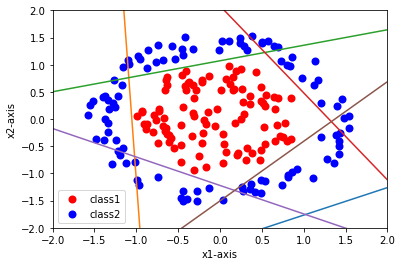

In [1788]:
p1x1,p1x2 = find_separation_line(-2,2,w[0],b[0])
p2x1,p2x2 = find_separation_line(-2,2,w[1],b[1])
p3x1,p3x2 = find_separation_line(-2,2,w[2],b[2])
p4x1,p4x2 = find_separation_line(-2,2,w[3],b[3])
p5x1,p5x2 = find_separation_line(-2,2,w[4],b[4])
p6x1,p6x2 = find_separation_line(-2,2,w[5],b[5])
p7x1,p7x2 = find_separation_line(-2,2,w[6],b[6])
p8x1,p8x2 = find_separation_line(-2,2,w[7],b[7])

plt.scatter(df0['x1'], df0['x2'], c ="red",
            linewidths = 2)
 
plt.scatter(df1['x1'], df1['x2'], c ="blue",
            linewidths = 2)
plt.plot(p1x1,p1x2)
plt.plot(p2x1,p2x2)
plt.plot(p3x1,p3x2)
plt.plot(p4x1,p4x2)
plt.plot(p5x1,p5x2)
plt.plot(p6x1,p6x2)
plt.plot(p7x1,p7x2)
plt.plot(p8x1,p8x2)

plt.xlabel("x1-axis")
plt.ylabel("x2-axis")
plt.legend(["class1" , "class2"])
plt.xlim([-2,2])
plt.ylim([-2, 2])
plt.show()

Text(0, 0.5, 'Loss')

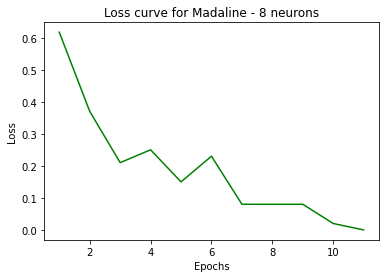

In [1789]:
itr = range(1,len(error_list)+1)
plt.plot(itr, error_list, 'g', label='Training loss')
plt.title('Loss curve for Madaline - 8 neurons')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [1790]:
y_hat = predict(x, t,w,b,d1=8)
print(classification_report(t, y_hat))

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       100
         1.0       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

